# Imports & basics

In [ ]:
# -- path info --
path_to_repo = "/Users/mbaranov/python_wd/credit_scoring_project"
dataset_nm = "07_pakdd"

# -- experiments logging --
experiment_dir = "test"
! mkdir "test"
# -- --

n_total = 200
top_k = 20

load = False                      # whether to train models or load from json

In [1]:
# --- base ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import json
import importlib
import optuna

import sys
seed = 89

# --- sklearn ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

# --- modules ---
sys.path.insert(1, path_to_repo)  # directory with modules
from modules.feature_selection import SafeSelectByShuffling
from modules.encoders import WoEEncoder_adj

import modules.optuna_instruments
from modules.optuna_instruments import optimized_function, get_top_k_models, get_top_test_scores


# --- load data ---
X_train = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/X_train.parquet")
y_train = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/y_train.parquet")["target"]
X_test = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/X_test.parquet")
y_test = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/y_test.parquet")["target"]
with open(f"{path_to_repo}/datasets/{dataset_nm}/factors.json", "r") as f:
    factors = json.load(f)

sample_info = {
    "X_train" : X_train,
    "y_train" : y_train,
    "X_test" : X_test, 
    "y_test" : y_test,
    "loss" : roc_auc_score
}

# Baseline pipeline

## Run models

In [4]:
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

# baseline modules
woe_encoder = WoEEncoder_adj(variables=factors["cat_vals"], ignore_format=True)
setattr(woe_encoder, "pipeline_nm", "cat_feat_WoEEnc")

Cat_imputer = CategoricalImputer(variables=factors["cat_vals"], fill_value="missing", ignore_format=True)
setattr(Cat_imputer, "pipeline_nm", "cat_nan_filling_Cat")

MM_imputer = MeanMedianImputer(imputation_method="median")
setattr(MM_imputer, "pipeline_nm", "nan_filling_MM")

# StandSc_module  = TransformerAdj(StandardScaler, '_scl')
StandSc_module = SklearnTransformerWrapper(StandardScaler(), variables=factors["num_vals"])
setattr(StandSc_module, "pipeline_nm", "scaling_StSc")

sel_shuffl = SafeSelectByShuffling(estimator=LogisticRegression(max_iter=500, solver="newton-cg"), min_features=1, variables=None, random_state=seed)
setattr(sel_shuffl, "pipeline_nm", "feat_sel_SelShuffl")

logreg = LogisticRegression(max_iter=1000, solver="newton-cg")
setattr(logreg, "pipeline_nm", "classifier_LogReg")

# no choice for baseline pipeline
stages_options_baseline = {
    "cat_nan_filling" : [Cat_imputer],
    "cat_feat" : [woe_encoder],
    "nan_filling" : [MM_imputer],
    # "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : [],
    "classifier" : [logreg]
}

# hparameters only for classifier
hparams_options_baseline = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [5]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_baseline.json", "r") as f:
        baseline_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_baseline = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed) 
        )

    study_baseline.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_baseline, hparams_options=hparams_options_baseline, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    baseline_results = [
        {"value" : study_baseline.trials[i].value, "params" : study_baseline.trials[i].params} for i in range(len(study_baseline.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_baseline.json", "w") as f:
        json.dump(baseline_results, f)

[I 2022-04-28 19:50:52,364] A new study created in memory with name: no-name-ed822a60-1c7f-4774-9e2e-415abfb83713
[I 2022-04-28 19:50:54,853] Trial 0 finished with value: 0.6049922634176126 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 50}. Best is trial 0 with value: 0.6049922634176126.
[I 2022-04-28 19:50:57,193] Trial 1 finished with value: 0.6049904933964998 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 26}. Best is trial 0 with value: 0.6049922634176126.
[I 2022-04-28 19:50:59,594] Trial 2 finished with value: 0.6049904933964998 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 26}. Best is trial 0 with value: 0.6049922634176126.
[I 2022-04-28 19:51:02,006] Trial 3 finished with value: 0.6049880029542203 and parameters: {'cat_nan_filling': 0, 

## Results

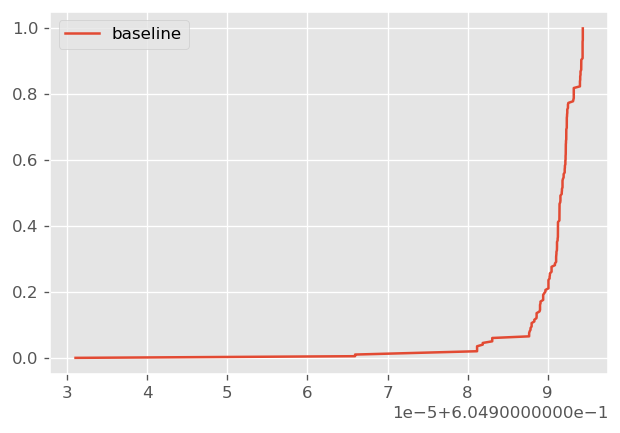

In [6]:
plt.figure(dpi=120)

auc_values_baseline = np.array([elem["value"] for elem in baseline_results])
t = np.linspace(0, 1, n_total)

plt.plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
plt.legend()

# plt.plot(auc_values);

In [8]:
# models_baseline = get_top_k_models(baseline_results, top_k=top_k, stages_options=stages_options_baseline)
scores_baseline = get_top_test_scores(baseline_results, top_k=top_k, stages_options=stages_options_baseline, **sample_info)
print(scores_baseline)

  0%|          | 0/20 [00:00<?, ?it/s]

[0.59957932 0.59957932 0.59957932 0.59957932 0.59957932 0.59957932
 0.59957932 0.59957932 0.59957932 0.59957932 0.59957932 0.59957932
 0.59957932 0.59957932 0.59957932 0.59957932 0.59957932 0.59957932
 0.59957932 0.59957932]


# Missing values imputation

## Run models

In [9]:
from feature_engine.imputation import RandomSampleImputer, AddMissingIndicator

class SafeAddMissingIndicator(AddMissingIndicator):
    """
    Modification of AddMissingIndicator also filling na with arbitrary_number.
    """

    def __init__(self, missing_only=False, variables=None, arbitrary_number=0):
        super().__init__(missing_only=missing_only, variables=variables)
        self.arbitrary_number = arbitrary_number

    def fit(self, X, y=None):
        super().fit(X, y)
        return self

    def transform(self, X):
        X = super().transform(X)
        X = X.fillna(self.arbitrary_number)

        return X

# -- additional missing values options --
Rand_imputer = RandomSampleImputer(seed="general", random_state=seed)
setattr(Rand_imputer, "pipeline_nm", "missing_Rand")

IndImp_imputer = SafeAddMissingIndicator()
setattr(IndImp_imputer, "pipeline_nm", "missing_IndImp")
# -- --

# no choice for baseline pipeline
stages_options_missing = {
    "cat_nan_filling" : [Cat_imputer],
    "cat_feat" : [woe_encoder],
    "nan_filling" : [MM_imputer, Rand_imputer, IndImp_imputer],
    # "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : [],
    "classifier" : [logreg]
}

# hparameters only for classifier
hparams_options_missing = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [10]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_missing.json", "r") as f:
        missing_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_missing = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_missing.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_missing, hparams_options=hparams_options_missing, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )


    # -- save results to json --
    missing_results = [
        {"value" : study_missing.trials[i].value, "params" : study_missing.trials[i].params} for i in range(len(study_missing.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_missing.json", "w") as f:
        json.dump(missing_results, f)

[I 2022-04-28 19:59:55,779] A new study created in memory with name: no-name-ce7b9ebf-93be-4c59-a032-c89396bebefd
[I 2022-04-28 19:59:58,287] Trial 0 finished with value: 0.6049880029542203 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 10}. Best is trial 0 with value: 0.6049880029542203.
[I 2022-04-28 20:00:00,865] Trial 1 finished with value: 0.604992295837423 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 49}. Best is trial 1 with value: 0.604992295837423.
[I 2022-04-28 20:00:06,605] Trial 2 finished with value: 0.6069750528490894 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 2, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 36}. Best is trial 2 with value: 0.6069750528490894.
[I 2022-04-28 20:00:09,365] Trial 3 finished with value: 0.6049923995800124 and parameters: {'cat_nan_filling': 0, 'c

## Results

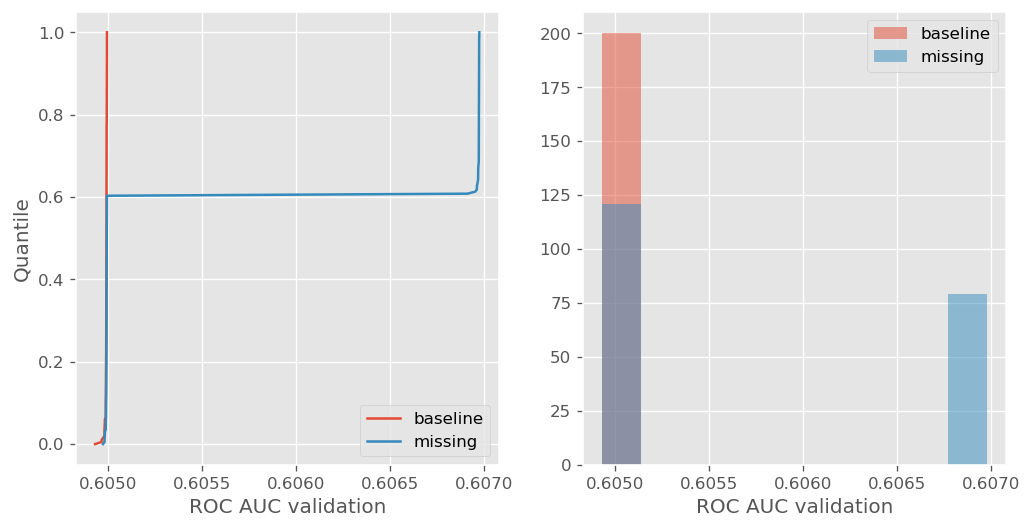

In [11]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_missing = np.array([elem["value"] for elem in missing_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_missing])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_missing), t, c="C1", label="missing")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_missing, bins=bin_edges, alpha=0.5, label="missing")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [12]:
scores_missing = get_top_test_scores(missing_results, top_k=top_k, stages_options=stages_options_missing, **sample_info)
print(np.mean(
    scores_missing.reshape(-1, 1) > scores_baseline
))

print(f"mean diff {np.mean(scores_missing) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

1.0
mean diff 0.001876


# Feature selection

## Run models

In [13]:
from modules.feature_selection import SafeSelectBySingleFeaturePerformance
from feature_engine.selection import SmartCorrelatedSelection

# -- additional feature selection options --
SinglePerf_module = SafeSelectBySingleFeaturePerformance(  # rather slow
    estimator=LogisticRegression(max_iter=500),
    scoring="roc_auc",
    threshold=None,               # will be automatically set to the mean performance value of all features
)
setattr(SinglePerf_module, "pipeline_nm", "feat_sel_SinglePerf")

SmartSel_module = SmartCorrelatedSelection(
    variables=None,                  # If None, the transformer will evaluate all numerical variables in the dataset.  -- нужен класс.
    method="pearson",                # can be replaced by a custom function
    threshold=0.3,                   # correlation threshold
    selection_method="variance",     # select feature with greatest variance from a correlated group
    estimator=None,                  # for selection_method="model_performance"        
    cv=5
)
setattr(SmartSel_module, "pipeline_nm", "feat_sel_SmartSel")
# --- ---

stages_options_feat_sel = {
    "cat_nan_filling" : [Cat_imputer],
    "cat_feat" : [woe_encoder],
    "nan_filling" : [MM_imputer],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl, SinglePerf_module, SmartSel_module],  # changes only here
    "imb_data" : [],
    "classifier" : [logreg]
}

hparams_options_feat_sel = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    },
    "feat_sel_SinglePerf" : lambda trial: {
        "feat_sel_SinglePerf__threshold" : trial.suggest_float("feat_sel_SinglePerf__threshold", low=0.5, high=0.6)
    }
}

In [ ]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_feat_sel.json", "r") as f:
        feat_sel_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_feat_sel = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_feat_sel.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_feat_sel, hparams_options=hparams_options_feat_sel, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    feat_sel_results = [
        {"value" : study_feat_sel.trials[i].value, "params" : study_feat_sel.trials[i].params} for i in range(len(study_feat_sel.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_feat_sel.json", "w") as f:
        json.dump(feat_sel_results, f)

## Results

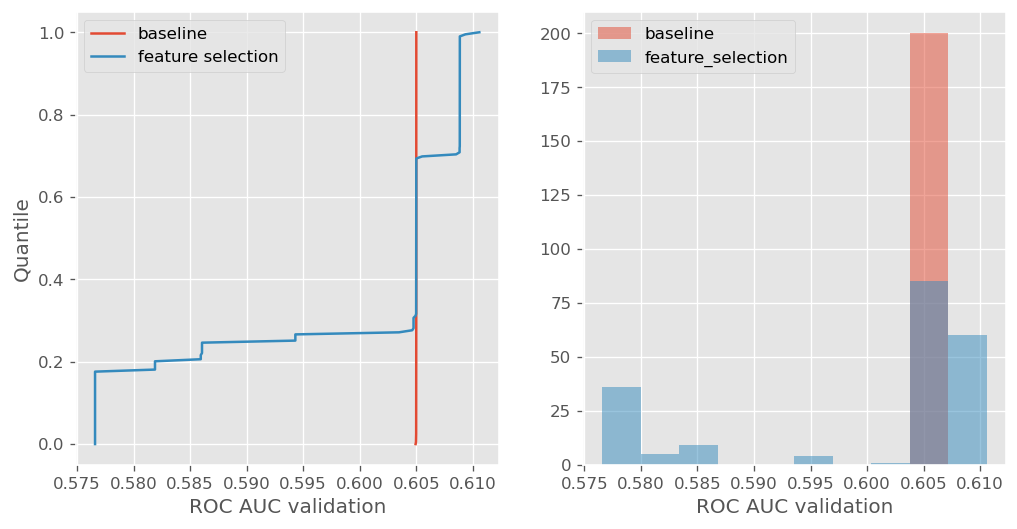

In [15]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_feat_sel = np.array([elem["value"] for elem in feat_sel_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_feat_sel])


ax[0].plot(np.sort(auc_values_baseline), np.linspace(0, 1, len(auc_values_baseline)), c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_feat_sel), np.linspace(0, 1, len(auc_values_feat_sel)), c="C1", label="feature selection")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_feat_sel, bins=bin_edges, alpha=0.5, label="feature_selection")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [16]:
scores_feat_sel = get_top_test_scores(feat_sel_results, top_k=top_k, stages_options=stages_options_feat_sel, **sample_info)
print(scores_feat_sel)
print(np.mean(
    scores_feat_sel.reshape(-1, 1) > scores_baseline
))

print(f"difference of max {np.max(scores_feat_sel) - np.max(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/mbaranov/miniforge3/envs/scoring_project/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:291: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/Users/mbaranov/miniforge3/envs/scoring_project/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:291: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/Users/mbaranov/miniforge3/envs/scoring_project/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:291: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/Users/mbaranov/miniforge3/envs/scoring_project/l

[0.6057002  0.60506534 0.60525989 0.60531674 0.6053156  0.60526964
 0.60533292 0.60527415 0.60531487 0.60533126 0.60533023 0.60533023
 0.60531793 0.60531793 0.60531793 0.60531793 0.60525024 0.60527182
 0.60533059 0.60533059]
1.0
difference of max 0.006121


# Imbalanced data

## Run models

In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# -- additional oversampling options --
ROS_module    = RandomOverSampler(random_state=seed)   # for all algorithms
setattr(ROS_module, "pipeline_nm", "imb_data_ROS")

SMOTE_module  = SMOTE(random_state=seed, n_jobs=-1)    # is to equalize
setattr(SMOTE_module, "pipeline_nm", "imb_data_SMOTE")

ADASYN_module = ADASYN(random_state=seed)              # the two classes
setattr(ADASYN_module, "pipeline_nm", "imb_data_ADASYN")

RUS_module = RandomUnderSampler(random_state=seed)
setattr(RUS_module, "pipeline_nm", "imb_data_RUS")

stages_options_imbalanced = {
    "cat_nan_filling" : [Cat_imputer],
    "cat_feat" : [woe_encoder],
    "nan_filling" : [MM_imputer],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip", ROS_module, RUS_module, SMOTE_module, ADASYN_module],  # changes only here
    "classifier" : [logreg]
}

hparams_options_imbalanced = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [19]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_imbalanced.json", "r") as f:
        imbalanced_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_imbalanced = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_imbalanced.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_imbalanced, hparams_options=hparams_options_imbalanced, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    imbalanced_results = [
        {"value" : study_imbalanced.trials[i].value, "params" : study_imbalanced.trials[i].params} for i in range(len(study_imbalanced.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_imbalanced.json", "w") as f:
        json.dump(imbalanced_results, f)

[I 2022-04-28 20:19:07,933] A new study created in memory with name: no-name-060ae3a1-b7f9-4507-9279-932570144b67
[I 2022-04-28 20:19:09,787] Trial 0 finished with value: 0.6051652718085073 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 4, 'classifier': 0, 'classifier_LogReg__C': 2}. Best is trial 0 with value: 0.6051652718085073.
[I 2022-04-28 20:19:11,705] Trial 1 finished with value: 0.6051717826724541 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 4, 'classifier': 0, 'classifier_LogReg__C': 36}. Best is trial 1 with value: 0.6051717826724541.
[I 2022-04-28 20:19:13,569] Trial 2 finished with value: 0.6050203524819093 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 1, 'classifier': 0, 'classifier_LogReg__C': 14}. Best is trial 1 with value: 0.6051717826724541.
[I 2022-04-28 20:19:15,464] T

## Results

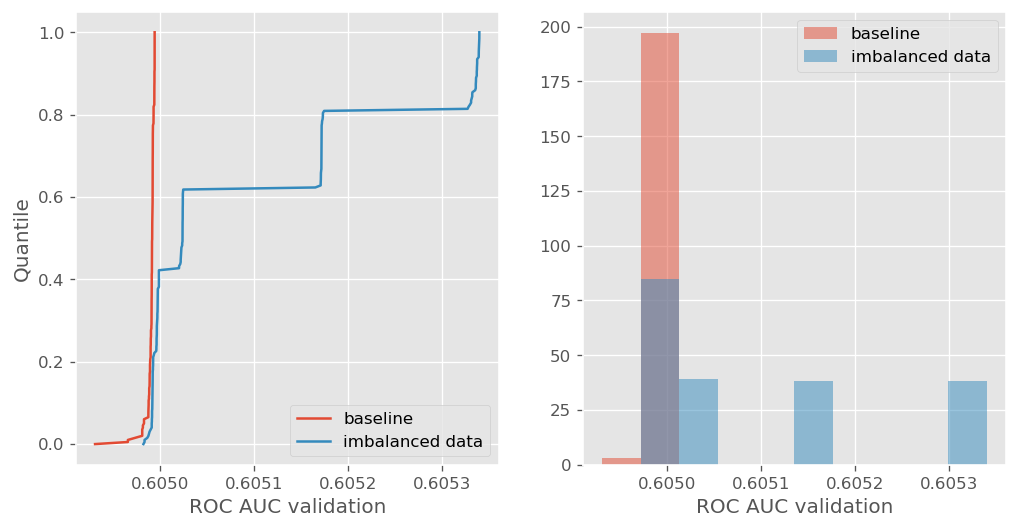

In [20]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_imbalanced = np.array([elem["value"] for elem in imbalanced_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_imbalanced])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_imbalanced), t, c="C1", label="imbalanced data")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_imbalanced, bins=bin_edges, alpha=0.5, label="imbalanced data")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [21]:
scores_imbalanced = get_top_test_scores(imbalanced_results, top_k=top_k, stages_options=stages_options_imbalanced, **sample_info)
print(np.mean(
    scores_imbalanced.reshape(-1, 1) > scores_baseline
))

print(f"mean diff {np.mean(scores_imbalanced) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

1.0
mean diff 0.000473


# Classifier choice

## Run models

In [22]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# change solver to allow for l1 penalty
setattr(logreg, "solver", "liblinear")

rf_classifier = RandomForestClassifier(random_state=seed)
setattr(rf_classifier, "pipeline_nm", "classifier_RF")

lgb_classifier = LGBMClassifier(random_state=seed)
setattr(lgb_classifier, "pipeline_nm", "classifier_LGB")

stages_options_classifier = {
    "cat_feat" : [woe_encoder],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip"],
    "classifier" : [logreg, lgb_classifier, rf_classifier]
}

stages_options_classifier = {
    "cat_nan_filling" : [Cat_imputer],
    "cat_feat" : [woe_encoder],
    "nan_filling" : [MM_imputer],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip"],
    "classifier" : [logreg, lgb_classifier, rf_classifier]  # changes only here
}

hparams_options_classifier = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__penalty" : trial.suggest_categorical("classifier_LogReg__penalty", ["l1", "l2"]),
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    },
    "classifier_RF" : lambda trial: {
        "classifier_RF__max_depth" : trial.suggest_categorical("classifier_RF__max_depth", [2, 4, 8, 16]),
        "classifier_RF__n_estimators" : trial.suggest_int("classifier_RF__n_estimators", low=100, high=1000, step=100),
    },
    "classifier_LGB" : lambda trial: {
        "classifier_LGB__boosting_type" : trial.suggest_categorical("classifier_LGB__boosting_type", ["gbdt", "goss"]),
        "classifier_LGB__max_depth" : trial.suggest_categorical("classifier_LGB__max_depth", [2, 4, 8, 16]),
        "classifier_LGB__n_estimators" : trial.suggest_int("classifier_LGB__n_estimators", low=50, high=300, step=50),
        "classifier_LGB__num_leaves" : trial.suggest_int("classifier_LGB__num_leaves", low=2, high=32, step=5),
    },
}

In [23]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_classifier.json", "r") as f:
        classifier_results = json.load(f)
else:
    # -- run grid search --
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
    study_classifier = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    strategy="kfold"
    study_classifier.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_classifier, hparams_options=hparams_options_classifier, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    classifier_results = [
        {"value" : study_classifier.trials[i].value, "params" : study_classifier.trials[i].params} for i in range(len(study_classifier.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_classifier.json", "w") as f:
        json.dump(classifier_results, f)

[I 2022-04-28 20:26:18,470] A new study created in memory with name: no-name-2633954f-7146-4c8d-a9db-0e6021c6d782
[I 2022-04-28 20:26:20,434] Trial 0 finished with value: 0.6049575411868584 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__penalty': 'l2', 'classifier_LogReg__C': 2}. Best is trial 0 with value: 0.6049575411868584.
[I 2022-04-28 20:26:25,444] Trial 1 finished with value: 0.5946421948043004 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 1, 'classifier_LGB__boosting_type': 'goss', 'classifier_LGB__max_depth': 8, 'classifier_LGB__n_estimators': 150, 'classifier_LGB__num_leaves': 22}. Best is trial 0 with value: 0.6049575411868584.
[I 2022-04-28 20:26:29,112] Trial 2 finished with value: 0.6054270463902529 and parameters: {'cat_nan_filling': 0, 'cat_feat': 0, 'nan_filling': 0, 'scaling': 0, '

## Results

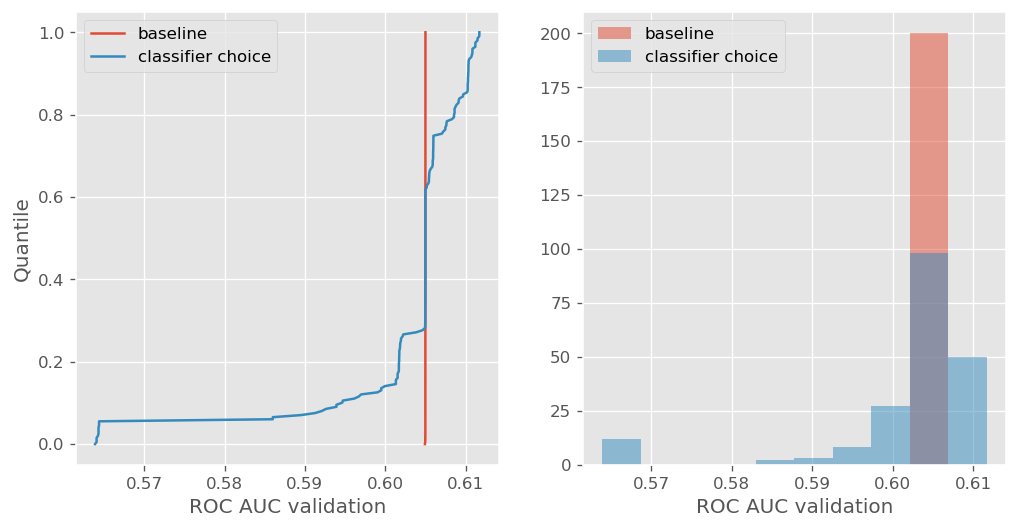

In [24]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_classifier = np.array([elem["value"] for elem in classifier_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_classifier])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_classifier), t, c="C1", label="classifier choice")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_classifier, bins=bin_edges, alpha=0.5, label="classifier choice")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [25]:
# models_baseline = get_top_k_models(baseline_results, top_k=top_k, stages_options=stages_options_baseline)
scores_classifier = get_top_test_scores(classifier_results, top_k=top_k, stages_options=stages_options_classifier, **sample_info)
print(scores_classifier)
print(np.mean(
    scores_classifier.reshape(-1, 1) > scores_baseline
))
print(f"mean diff {np.mean(scores_classifier) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

[0.60991384 0.60991384 0.61000101 0.60943289 0.60943289 0.60809595
 0.60809595 0.60809595 0.60963825 0.60865611 0.60865611 0.60941224
 0.61018192 0.60941559 0.60930604 0.60930604 0.60926283 0.60926283
 0.60926283 0.60926283]
1.0
mean diff 0.009651
